In [1]:
''' Check if we running in google colab'''

REPO_NAME="EP-in-DNN"

try:
    import google.colab
    IN_COLAB = True
    %tensorflow_version 2.x
    ! rm -rf "EP-in-DNN"
    ! git clone "https://github.com/kaibrach/EP-in-DNN"
except:
    IN_COLAB = False

%matplotlib inline
from IPython.core.debugger import set_trace
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import logging
import sys
import os
import glob
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import urllib.request
import pandas as pd
import tensorflow as tf

# Import ErrorPropagation Class (see src/ErrorPropagation)
# append the upper directory for importing modules
if IN_COLAB:
    sys.path.append(REPO_NAME)

sys.path.append("..")
import src.ErrorPropagation as ep

tfk = tf.keras

''' Disable Eager Execution for fast execution of the graph'''
#tf.compat.v1.disable_eager_execution()

'''
    Need to import private functions from tensorflow.python.keras instead of tf.keras.backend 
    to get symbolic_learning_phase() to use with K.function an eager execution enabled. 
    Otherwise we will run into an error
    see my entry on https://github.com/tensorflow/tensorflow/issues/34201
'''
from tensorflow.python.keras import backend as K

if not IN_COLAB:
    # suppress annoying Tensorflow warnings
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = '-1' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

    # https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    cpus = tf.config.experimental.list_physical_devices('CPU')

    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
    elif cpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            logical_cpus= tf.config.experimental.list_logical_devices('CPU')
            print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
        
K.clear_session()

1 Physical CPU, 1 Logical CPU


In [3]:
l2 = tfk.regularizers.l2
Input = tfk.layers.Input
Dropout = tfk.layers.Dropout
Dense = tfk.layers.Dense
Lambda = tfk.layers.Lambda
Conv2D = tfk.layers.Conv2D
MaxPooling2D = tfk.layers.MaxPool2D
AveragePooling2D = tfk.layers.AveragePooling2D
Flatten = tfk.layers.Flatten
Model = tfk.models.Model


class net:

    def __init__(self, X_train, y_train,
                 n_filter=[32,64],
                 n_hidden=[256,128], 
                 tau = 0.1, 
                 dropout = 0.3, 
                 activation_fct='relu',
                 pooling='',
                 print_summary=False):

        """
            Constructor for the class implementing a Bayesian neural network
            trained with the probabilistic back propagation method.
            @param X_train      Matrix with the features for the training data.
            @param y_train      Vector with the target variables for the
                                training data.
            @param n_hidden     Vector with the number of neurons for each
                                hidden layer.
            @param dropout      Dropout rate for all the dropout layers in the
                                network.
        """

        self._trained = False
        self._ep = None
        
        self._X_train = X_train
        self._y_train = y_train
        
        self._initializer = 'he_normal'
        self._filters = n_filter
        self._kernels = (3, 3)
        self._pool_length = (2, 2)
        self._strides = (1,1)
        self._padding = 'same'
        if pooling == '':
            print('No Pooling set Conv2D stride to (2,2) for Downsampling')
            #https://www.quora.com/Why-do-we-use-max-pooling-whereas-we-can-use-a-stride-of-2-during-a-convolution
            # https://mirror2image.wordpress.com/2014/11/11/geoffrey-hinton-on-max-pooling-reddit-ama/
            self._strides = (2,2)
        
        # We construct the network
        N = self._X_train.shape[0]
        
        lengthscale = 1e-2
        reg = lengthscale**2 * (1 - dropout) / (2. * N * tau)

        ''' Create CNN'''
        inputs = Input(shape=(self._X_train.shape[1:]), name='input')

        # CNN Layer with dropout
        x = Conv2D(filters=self._filters[0],
                   kernel_size=self._kernels,
                   strides = self._strides,
                   padding=self._padding,
                   activation=activation_fct,
                   kernel_initializer=self._initializer,
                   kernel_regularizer=l2(reg))(inputs)
        # Pooling
        if pooling == 'max':
            x = MaxPooling2D(pool_size=self._pool_length)(x)
        elif pooling == 'avg':
            x = AveragePooling2D(pool_size=self._pool_length)(x)
            
        x = Dropout(rate=dropout)(x)

        ''' Create CNN layers'''
        for i in range(len(self._filters)-1):
            x = Conv2D(filters=self._filters[i+1],
                       kernel_size=self._kernels,
                       strides = self._strides,
                       padding=self._padding,
                       activation=activation_fct,
                       kernel_initializer=self._initializer,
                       kernel_regularizer=l2(reg))(x)
            # Pooling
            if pooling == 'max':
                x = MaxPooling2D(pool_size=self._pool_length,
                                 padding=self._padding
                                )(x)
            elif pooling == 'avg':
                x = AveragePooling2D(pool_size=self._pool_length,
                                     padding=self._padding
                                    )(x)
                
            x = Dropout(rate=dropout)(x)

        # Flatten the data
        x = Flatten()(x)

        ''' Create hidden layers'''
        for h in n_hidden:
            x = Dense(units=h, activation=activation_fct, kernel_regularizer=l2(reg))(x)
            x = Dropout(rate=dropout)(x)

        #x = Dropout(rate=dropout)(x)
        outputs = Dense(units=self._y_train.shape[-1],
                        activation='softmax',
                        name='output')(x)


        ''' Create the model'''
        self._model = Model(inputs, outputs)

        self._model.compile(
                           #loss = tf.nn.softmax_cross_entropy_with_logits, #Enable if softmax is not output activation func
                           loss='categorical_crossentropy', 
                           optimizer='adam',
                           metrics=['accuracy'])
        if print_summary:
            print(self._model.summary())
    

    @property
    def model(self):
        return self._model
    
    @property
    def ep_model(self):
        if self._ep is not None:
            return self._ep.model
        else:
            return None

    @model.setter
    def model(self, value):
        self._trained = True
        self._model = value

    def train(self, batch_size, n_epochs, verbose,checkpoint_path='checkpoints'):
        from datetime import datetime

        def lr_scheduler(epoch):
            if epoch < 10:
                return 0.001
            else:
                return 0.001 * tf.math.exp(0.1 * (10 - epoch))

        logdir = "logs\\cifar10\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
        
        ''' Create dir for checkpoints'''
        if not os.path.exists(checkpoint_path):
            os.makedirs(checkpoint_path)  
            
        tensorboard_callback = tfk.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1,profile_batch=0)
        filename = 'weights__epoch-{epoch:02d}__val_loss-{val_loss:.4f}__val_acc-{val_accuracy:.4f}.hdf5'
        checkpoint_cbk = tfk.callbacks.ModelCheckpoint(filepath=f'{checkpoint_path}\\{filename}',
                                                       monitor='val_loss',
                                                       save_best_only=True,
                                                       verbose=1)
        
        early_stopping_cbk = tfk.callbacks.EarlyStopping(monitor='val_loss',
                                                         min_delta=0,
                                                         verbose=1,
                                                         patience=10,
                                                         mode='auto',
                                                         baseline=None,
                                                         restore_best_weights=False)
        
        reduce_LROnPlateau_cbk = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                 factor=0.2,
                                                                 patience=6,
                                                                 verbose=1,
                                                                 min_delta=0.00005,
                                                                 cooldown=0,
                                                                 min_lr= 0.000001)

        lr_scheduler_cbk = tfk.callbacks.LearningRateScheduler(lr_scheduler,verbose=1)

        hist = self.model.fit(self._X_train, self._y_train,
                              validation_split=0.2,
                              shuffle=True,
                              batch_size=batch_size,
                              epochs=n_epochs,
                              verbose=verbose,
                              callbacks=[
                                          checkpoint_cbk,
                                          early_stopping_cbk,
                                          #reduce_LROnPlateau_cbk,
                                          lr_scheduler_cbk
                                         ]
                              )
        

        self._trained = True
        return hist

    
    def predict(self, X_test, y_test):
        
        assert self._trained == True, 'Please train the network before prediction!'
                             
        
        ''' Create Keras backand function with "ALL" Errorprop outputs'''
        f = K.function([self.model.layers[0].input, 
                        #K.learning_phase()],
                        K.symbolic_learning_phase()], # Workaround (maybe slowdown)
                        [self.model.output])
        
        ''' Start Runtime'''
        start = time.time()
        
        ''' Disable dropout in forwardpass (K.learning_phase() = False]'''
        preds = f((X_test, False))[0]
        
        ''' Stop Runtime'''
        rt = time.time() - start

        ''' Get the predicted class'''
        preds_class = np.argmax(preds, axis=1)

        ''' Get the standard deviation'''
        std = np.zeros_like(preds_class, dtype=float)

        ''' Calculate entropy and nll and rmse'''
        entropy = np.ones_like(preds_class, dtype=float)
        for i in range(preds_class.shape[0]):
            all_prediction = np.array(preds[i, :])
            all_prediction = all_prediction.clip(min=1e-11, max=1 - 1e-11)
            entropy[i] = - np.sum(all_prediction * np.log(all_prediction))

        pred_max_p = np.array([preds[i][np.argmax(preds[i])] for i in range(0, len(preds))])
        nll = -np.log(pred_max_p)
        #rmse = np.sqrt(np.mean((y_test.squeeze() - preds.squeeze())**2.))
        
        return preds, preds_class, std, entropy, nll, rt

    
    def predict_mc(self, X_test, y_test, mc_samples):
        
        assert self._trained == True, 'Please train the network before prediction!'
            
        ''' Create Keras backand function for enabling dropout in fw-pass'''       
        f = K.function([self.model.layers[0].input, 
                        #K.learning_phase()],
                        K.symbolic_learning_phase()], # Workaround (maybe slowdown)
                        [self.model.output])
    
        ''' Start Runtime'''
        start = time.time()
        
        ''' Run the function mc_samples with learning_phase flag = True (Dropout enabled in fw-pass)'''
        mc_preds = np.array([f((X_test, True))[0] for _ in range(mc_samples)])
        
        ''' Stop Runtime'''
        rt = time.time() - start
        
        ''' Get the predicted class'''
        preds = np.mean(mc_preds, axis=0)
        preds_class = np.argmax(preds, axis=1)
                
        ''' Get the standard deviation'''
        std = np.sqrt(np.sum(np.var(mc_preds, axis=0), axis=1))

        ''' Calculate entropy and nll and rmse'''
        entropy = np.ones_like(preds_class, dtype=float)
        for i in range(preds_class.shape[0]):
            all_prediction = np.array(preds[i, :])
            all_prediction = all_prediction.clip(min=1e-11, max=1 - 1e-11)
            entropy[i] = -np.sum(all_prediction * np.log(all_prediction))

        pred_max_p = np.array([preds[i][np.argmax(preds[i])] for i in range(0, len(preds))])
        nll = -np.log(pred_max_p)
        #rmse = np.sqrt(np.mean((y_test.squeeze() - preds.squeeze())**2.))

        
        return preds, preds_class, std, entropy, nll, rt

    
    def predict_ep(self, X_test, y_test=None, use_gaussian_relu=False, verbose=False):
                      
        ''' Create ErrorPropagation Model here'''
        if self._ep is None:
            self._ep = ep.EP(self.model)

        ''' Create the EP Model '''
        self._ep.create_EP_Model(use_gaussian_relu=use_gaussian_relu, verbose=verbose)


        ''' Create Keras backand function with "ALL" Errorprop outputs'''
        f = K.function([self._ep.model.layers[0].input,
                        #K.learning_phase()],
                        K.symbolic_learning_phase()],  # Workaround (maybe slowdown)
                       [self._ep.model.output])
        
        ''' Start Runtime '''
        start = time.time()
        
        ''' Disable dropout in forwardpass (K.learning_phase() = False]'''
        preds, var = f((X_test, False))[0]
        
        ''' Stop Runtime'''
        rt = time.time() - start
        
        ''' Get the predicted class'''
        preds_class = np.argmax(preds, axis=1)

        ''' Get the standard deviation'''
        std = np.sqrt(np.sum(var,axis=1))
        ''' Calculate entropy and nll and rmse'''
        entropy = np.ones_like(preds_class, dtype=float)
        for i in range(preds_class.shape[0]):
            all_prediction = np.array(preds[i, :])
            all_prediction = all_prediction.clip(min=1e-11, max=1 - 1e-11)
            entropy[i] = - np.sum(all_prediction * np.log(all_prediction))

        pred_max_p = np.array([preds[i][np.argmax(preds[i])] for i in range(0, len(preds))])
        nll = -np.log(pred_max_p)
        #rmse = np.sqrt(np.mean((y_test.squeeze() - preds.squeeze())**2.))
        
        return preds, preds_class, std, entropy, nll, rt
    

In [4]:
# Specify the classes you want to exclude from the Trainingset
LABELS=np.arange(0,43)
LABELS_IDX = range(0,len(LABELS))

''' Set the index of the excluded label here. If no label shall be excluded, return an empty list[]'''
EXCLUDED_LABELS_IDX=[1,11,21,31,41]# Exlude 1,11,21,31,41
INCLUDED_LABELS_IDX= list(set(LABELS_IDX)-set(EXCLUDED_LABELS_IDX))

In [5]:
''' Return all indices that are excluded from the dataset'''
def get_excluded_idx(y, excludeNo=None,ret_mask=False):
    # small check if the input is categorical
    # e.g. not categorical --> (1000,)
    # e.g. categorical --> (1000,10)
    if len(y[0]) > 1:
        y = np.argmax(y, axis=1)
    
    mask = np.isin(y,excludeNo)
    if ret_mask:
        return mask
    return np.where(mask)[0]

''' Return all indices that are included in the dataset'''
def get_included_idx(y, excludeNo=None,ret_mask=False):
    # small check if the input is categorical
    # e.g. not categorical --> (1000,)
    # e.g. categorical --> (1000,10)
    if len(y[0]) > 1:
        y = np.argmax(y, axis=1)
        
    mask = np.isin(y,excludeNo)==False
    if ret_mask:
        return mask
    
    return np.where(mask)[0]  

In [6]:
# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels
def readTrafficSigns(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 42 classes
    for c in range(0,43):
        prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
        gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        header = next(gtReader) # skip header
        # loop over all images in current annotations file
        for row in gtReader:
            images.append(plt.imread(prefix + row[0])) # the 1th column is the filename
            labels.append(row[7]) # the 8th column is the label
        gtFile.close()
    return images, labels

In [7]:
import csv
rootpath = "C:/Users/MJY/Desktop/konstanz-deeplearning/教授给的资料/error_propagation/images";
images, labels = readTrafficSigns(rootpath)

In [8]:
import cv2
image_resize = np.zeros((len(images), 32, 32, 3))
i = 0
for image in images:
    image_resize[i] = cv2.resize(image, (32,32))
    i = i+1
image_train = image_resize.astype(np.int32)   #注意必须强转为整型，否则浮点型显示不出来

label_train = np.zeros((len(images),1))
for i in range(len(images)):
    label_train[i] = eval(labels[i])
label_train = label_train.astype(np.int32)  #注意必须强转为整型，否则浮点型会导致预测有问题

image_train.shape, label_train.shape

((39209, 32, 32, 3), (39209, 1))

In [9]:
# 分一下训练集和测试集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_train, label_train, test_size=0.25)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train, X_test = X_train / 255.0, X_test / 255.0

print('(Before) X_train shape:', X_train.shape)
print('(Before) y_train shape:', y_train.shape)
print('(Before) X_test shape:', X_test.shape)
print('(Before) y_test shape:', y_test.shape)


train_excluded_idx = get_excluded_idx(y_train, excludeNo=EXCLUDED_LABELS_IDX)
train_included_idx = get_included_idx(y_train, excludeNo=EXCLUDED_LABELS_IDX)
test_exclude_idx = get_excluded_idx(y_test, excludeNo=EXCLUDED_LABELS_IDX)
test_include_idx = get_included_idx(y_test, excludeNo=EXCLUDED_LABELS_IDX)

'''Delete all images and labels that should not be part of the training-set'''
X_train = np.delete(X_train, train_excluded_idx, axis=0) # necessary to delete the rows (axis=0)
y_train = np.delete(y_train, train_excluded_idx)

''' Set the new output to categorical'''
y_train=np.array(pd.get_dummies(y_train))

print('(Final) X_train shape:', X_train.shape)
print('(Final) y_train shape:', y_train.shape)
print('(Final) X_test shape:', X_test.shape)
print('(Final) y_test shape:', y_test.shape)

(Before) X_train shape: (29406, 32, 32, 3)
(Before) y_train shape: (29406, 1)
(Before) X_test shape: (9803, 32, 32, 3)
(Before) y_test shape: (9803, 1)
(Final) X_train shape: (25724, 32, 32, 3)
(Final) y_train shape: (25724, 38)
(Final) X_test shape: (9803, 32, 32, 3)
(Final) y_test shape: (9803, 1)


In [10]:
def plot_history(history):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## 建立average pooling的网络模型

In [11]:
''' Specifiy the folder for loading an already saved model or for storing a new model'''
SAVED_FOLDER_avg='saved/GTSRB_exclude_5classes_avg_pooling'
# SAVED_FOLDER='saved/cifar10_exclude_deer_no_pooling_stride_2x2'
#SAVED_FOLDER='saved/cifar10_exclude_deer_max_pooling'
ANALYTICAL = True # False: use approximation, True: use Gaussian_ReLU

tfk.backend.clear_session()
dropout=0.3
pooling='avg' # possible values are [avg, max or '']. If pooling='' we will use a convolution stride of (2,2)
nn_avg = net(X_train, y_train, 
         n_filter=[32,64,64,128],
         n_hidden=[],         # No additional hidden Dense layers
         dropout=dropout,
         pooling=pooling)

## 建立max pooling的网络模型

In [12]:
''' Specifiy the folder for loading an already saved model or for storing a new model'''
# SAVED_FOLDER='saved/ifar10_exclude_deer_avg_pooling'
# SAVED_FOLDER='saved/cifar10_exclude_deer_no_pooling_stride_2x2'
SAVED_FOLDER_max='saved/GTSRB_exclude_5classes_max_pooling'
ANALYTICAL = True # False: use approximation, True: use Gaussian_ReLU

tfk.backend.clear_session()
dropout=0.3
pooling='max' # possible values are [avg, max or '']. If pooling='' we will use a convolution stride of (2,2)
nn_max = net(X_train, y_train, 
         n_filter=[32,64,64,128],
         n_hidden=[],         # No additional hidden Dense layers
         dropout=dropout,
         pooling=pooling)

In [13]:
nn_max.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0     

In [14]:
y_test.shape

(9803, 1)

In [15]:
len(np.unique(y_test))

43

In [16]:
''' Set the training hyperparameters (only used if the model could not be loaded)'''
BATCH_SIZE = 128
N_EPOCHS = 400  # 要有足够的epochs，从而保证网络具有极限性能而验证集保证了其过拟合程度

# avg_pooling
try:
    ''' Try to load an already trained model'''
    print(f'Loading model {SAVED_FOLDER_avg+"/model.hdf5"}... ')
    nn_avg.model = tf.keras.models.load_model(SAVED_FOLDER_avg+'/model.hdf5')
            
except OSError as e:
    print(e)
    print(f'Start training new model and store it to {SAVED_FOLDER_avg+"/model.hdf5"}... ')
    os.mkdir(SAVED_FOLDER_avg)
    
    hist_avg = nn_avg.train(BATCH_SIZE, N_EPOCHS, verbose=1, checkpoint_path=SAVED_FOLDER_avg)
    plot_history(hist_avg)
    
    ''' Save the new model '''
    nn_avg.model.save(SAVED_FOLDER_avg+'/model.hdf5')
    
          
          
          
# ---------------------------------------------------------------------------------------------------------------------------

# max_pooling
try:
    ''' Try to load an already trained model'''
    print(f'Loading model {SAVED_FOLDER_max+"/model.hdf5"}... ')
    nn_max.model = tf.keras.models.load_model(SAVED_FOLDER_max+'/model.hdf5')
            
except OSError as e:
    print(e)
    print(f'Start training new model and store it to {SAVED_FOLDER_max+"/model.hdf5"}... ')
    os.mkdir(SAVED_FOLDER_max)
    
    hist_max = nn_max.train(BATCH_SIZE, N_EPOCHS, verbose=1, checkpoint_path=SAVED_FOLDER_max)
    plot_history(hist_max)
    
    ''' Save the new model '''
    nn_max.model.save(SAVED_FOLDER_max+'/model.hdf5')


          
# summary---------------------------------------------------------------------------------------------------------------------------

nn_list = [nn_avg, nn_max]
          
for nn in nn_list:
    ''' Plot the class names of the network'''
    if nn == nn_avg:
        print('\n----AVG Model Summary ----')
    else:
        print('\n----MAX Model Summary ----')
    for i in range(len(nn.model.layers)):
        layer = nn.model.layers[i]
        print(i, layer.__class__.__name__, layer.output.shape)

    ''' Test include and exclude accuracy '''
    loss, accuracy  = nn.model.evaluate(x=X_test[test_include_idx],
                                        y=pd.get_dummies(y_test[test_include_idx][:,0]), 
                                        verbose=False)

    print('\n---- Model Evaluation (Included Data) ----')
    print(f'Test loss: {loss:.5}')
    print(f'Test accuracy: {accuracy:.5}')
#     loss, accuracy  = nn.model.evaluate(x=X_test[test_exclude_idx],
#                                             y=tf.keras.utils.to_categorical(y_test[test_exclude_idx],
#                                                                             num_classes=y_train.shape[-1]), 
#                                             verbose=False)
#     print('\n---- Model Evaluation (Excluded Data) ----')
#     print(f'Test loss: {loss:.5}')
#     print(f'Test accuracy: {accuracy:.5}')

#     tf.keras.utils.plot_model(
#         nn.model, to_file='model.png', show_shapes=True, show_layer_names=False,
#         rankdir='TB', expand_nested=True, dpi=96
#     )


Loading model saved/GTSRB_exclude_5classes_avg_pooling/model.hdf5... 
Loading model saved/GTSRB_exclude_5classes_max_pooling/model.hdf5... 

----AVG Model Summary ----
0 InputLayer (None, 32, 32, 3)
1 Conv2D (None, 32, 32, 32)
2 AveragePooling2D (None, 16, 16, 32)
3 Dropout (None, 16, 16, 32)
4 Conv2D (None, 16, 16, 64)
5 AveragePooling2D (None, 8, 8, 64)
6 Dropout (None, 8, 8, 64)
7 Conv2D (None, 8, 8, 64)
8 AveragePooling2D (None, 4, 4, 64)
9 Dropout (None, 4, 4, 64)
10 Conv2D (None, 4, 4, 128)
11 AveragePooling2D (None, 2, 2, 128)
12 Dropout (None, 2, 2, 128)
13 Flatten (None, 512)
14 Dense (None, 38)

---- Model Evaluation (Included Data) ----
Test loss: 0.043836
Test accuracy: 0.99232

----MAX Model Summary ----
0 InputLayer (None, 32, 32, 3)
1 Conv2D (None, 32, 32, 32)
2 MaxPooling2D (None, 16, 16, 32)
3 Dropout (None, 16, 16, 32)
4 Conv2D (None, 16, 16, 64)
5 MaxPooling2D (None, 8, 8, 64)
6 Dropout (None, 8, 8, 64)
7 Conv2D (None, 8, 8, 64)
8 MaxPooling2D (None, 4, 4, 64)
9 Drop

## 先拿到预测

In [17]:
# nn_list[0].model.summary(),nn_list[1].model.summary()

In [18]:
''' Get the prediction, standard deviation, RootMeanSquared Error and Runtime from Error Propagation Model'''
MC_SAMPLES=30  # 前向传播30次
prediction_elements = ['pred','pred_label','std','entropy','nll','rt']

''' Create a list of prediction dictionaries'''
preds_dict_avg = []
preds_dict_max = []

for i in range(2):
    preds_dict = []
    
    nn = nn_list[i]
    ''' MC-Dropout'''
    preds_mc_dict = dict(zip(prediction_elements, nn.predict_mc(X_test, y_test,MC_SAMPLES)))
    preds_mc_dict.update({'name':'MC'})
    preds_mc_label =  np.array([INCLUDED_LABELS_IDX[np.argmax(preds_mc_dict['pred'],axis=1)[j]] for j in range(0,len(preds_mc_dict['pred']))])
    preds_mc_dict.update({'pred_label':preds_mc_label})
    preds_mc_dict.update({'true_label':y_test[:,0]})

    ''' ErrorProp'''
    preds_ep_dict = dict(zip(prediction_elements, nn.predict_ep(X_test, y_test,use_gaussian_relu=ANALYTICAL,verbose=False)))
    preds_ep_dict.update({'name':'EP'})                    
    preds_ep_label =  np.array([INCLUDED_LABELS_IDX[np.argmax(preds_ep_dict['pred'],axis=1)[j]] for j in range(0,len(preds_ep_dict['pred']))]) 
    preds_ep_dict.update({'pred_label':preds_ep_label})
    preds_ep_dict.update({'true_label':y_test[:,0]})
    


    ''' Create a list of all dictionaries'''
    #preds_dict.append(preds_single_dict)
    preds_dict.append(preds_mc_dict)
    preds_dict.append(preds_ep_dict)
    
    if i == 0:
        preds_dict_avg = preds_dict
    else:
        preds_dict_max = preds_dict

## 直接过滤实验，看看谁的效果更好

In [19]:
def unc_filtered_acc(preds_dictionary, u_type='std',k_elements=1000,enable_print=False): 
    
    '''Needed variables'''
    unc_type_vals = preds_dictionary[u_type] # std, entropy or nll
    true_labels = preds_dictionary['true_label']
    pred_labels = preds_dictionary['pred_label'] # Correct mapping to the included indices done 
        
    ''' Indices of k_elements sorted'''
    low_unc_idx = (unc_type_vals).argsort()[:k_elements]   
    
    ''' Calculate the metric based on the sorted indices'''
    acc = tf.keras.metrics.Accuracy()
    acc.update_state(true_labels[low_unc_idx],pred_labels[low_unc_idx])
    
    if enable_print:
        print(f'{preds_dictionary["name"]}: Accuracy filtered={acc.result().numpy():.3f}\
        (k_elements={k_elements}, Filter={u_type})')

    ''' Return the measured accuracy'''
    return acc.result().numpy()


def unc_filtered_acc_loop(preds_dictionary, u_type='std',k_elements=1000):  # preds_dict[0],'std',k_elements
    
    '''Needed variables'''
    unc_type_vals = preds_dictionary[u_type] # std, entropy or nll
    true_labels = preds_dictionary['true_label']
    pred_labels = preds_dictionary['pred_label'] # Correct mapping to the included indices done    
    
    ''' Indices of k_elements sorted'''
    low_unc_idx = (unc_type_vals).argsort()[:k_elements]   
    
    ''' Calculate the metric based on the sorted indices'''
    acc = tf.keras.metrics.Accuracy()
    result = np.zeros(len(low_unc_idx))

    for j,idx in enumerate(low_unc_idx):
        acc.update_state(true_labels[idx],pred_labels[idx])
        result[j] = acc.result().numpy()

    ''' Return the measured accuracy'''
    return result

def plot_additional_infos(mc_accs,ep_accs):  # plot_additional_infos(mc_results,ep_results)
    ''' Do some additional fancy plots'''
    # Both calculations are the same
    diff = np.abs(np.subtract(mc_accs,ep_accs))
    #diff = np.abs(np.diff(np.array([mc_accs, ep_accs]), axis=0))[0]
    maxpoint = np.argmax(diff)

    plt.vlines(x=maxpoint,ymin=mc_accs[maxpoint], ymax=ep_accs[maxpoint], 
               color='green',label=f'max diff at {maxpoint} ({diff[maxpoint]:.4f})')
    
    plt.text(x=maxpoint, y=((mc_accs[maxpoint] + ep_accs[maxpoint])/2) , 
             s=f'{diff[maxpoint]:.4f}', rotation=0, verticalalignment='center',color='green')
    
    # plt.vlines(x=maxpoint,ymin=diff[maxpoint], 
    #            ymax=ep_results[maxpoint], color='green',linestyles='dashed')
    # plt.plot(diff,label=f'diff at {maxpoint}')

    # Add extra tick to x axis (looks weird if points close by)
    #plt.xticks(list(plt.xticks()[0]) + [maxpoint])

(9803,)


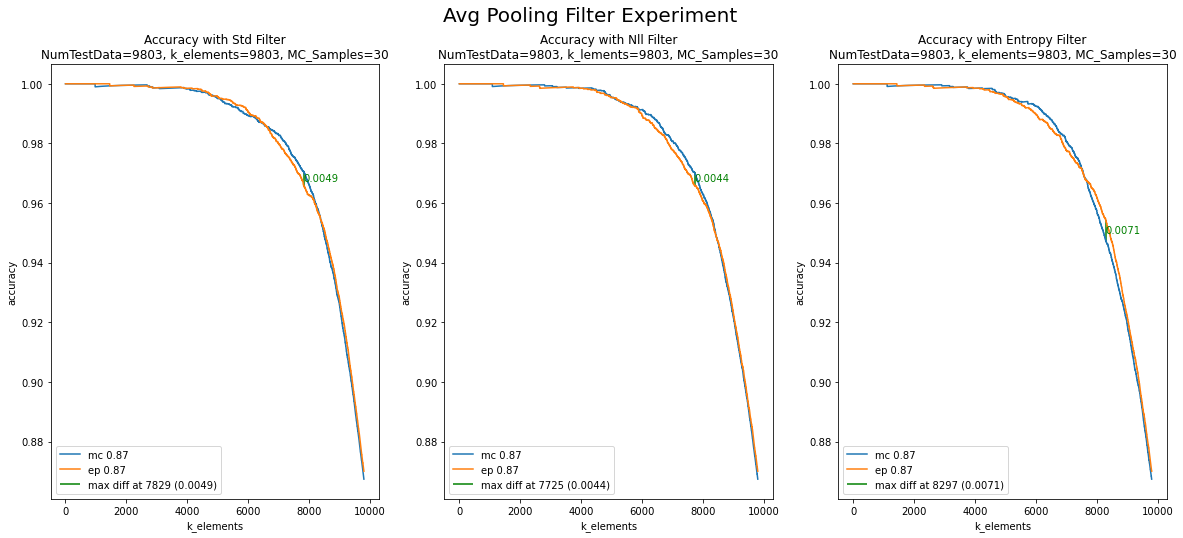

In [20]:
preds_dict = preds_dict_avg
k_elements = X_test.shape[0]
plt.figure(figsize=(20,8))

##########################
plt.subplot(1,3,1)
plt.suptitle("Avg Pooling Filter Experiment",fontsize=20)

mc_results = unc_filtered_acc_loop(preds_dict[0],'std',k_elements)
ep_results = unc_filtered_acc_loop(preds_dict[1],'std',k_elements)

'''Plot the results'''
plt.plot(mc_results,label=f'mc {mc_results[-1]:.2f}')
plt.plot(ep_results,label=f'ep {ep_results[-1]:.2f}')

'''Plot some additional stuff'''
plot_additional_infos(mc_results,ep_results)

plt.title(f'Accuracy with Std Filter\nNumTestData={len(y_test)}, k_elements={k_elements}, MC_Samples={MC_SAMPLES}')
plt.xlabel('k_elements')
plt.ylabel("accuracy")
plt.legend()

##########################
plt.subplot(1,3,2)

mc_results = unc_filtered_acc_loop(preds_dict[0],'nll',k_elements)
ep_results = unc_filtered_acc_loop(preds_dict[1],'nll',k_elements)

'''Plot the results'''
plt.plot(mc_results,label=f'mc {mc_results[-1]:.2f}')
plt.plot(ep_results,label=f'ep {ep_results[-1]:.2f}')
print(mc_results.shape)

'''Plot some additional stuff'''
plot_additional_infos(mc_results,ep_results)

plt.title(f'Accuracy with Nll Filter\nNumTestData={len(y_test)}, k_lements={k_elements}, MC_Samples={MC_SAMPLES}')
plt.xlabel('k_elements')
plt.ylabel("accuracy")
plt.legend()

##########################
plt.subplot(1,3,3)

mc_results = unc_filtered_acc_loop(preds_dict[0],'entropy',k_elements)
ep_results = unc_filtered_acc_loop(preds_dict[1],'entropy',k_elements)

'''Plot the results'''
plt.plot(mc_results,label=f'mc {mc_results[-1]:.2f}')
plt.plot(ep_results,label=f'ep {ep_results[-1]:.2f}')

'''Plot some additional stuff'''
plot_additional_infos(mc_results,ep_results)

plt.title(f'Accuracy with Entropy Filter\nNumTestData={len(y_test)}, k_elements={k_elements}, MC_Samples={MC_SAMPLES}')
plt.xlabel('k_elements')
plt.ylabel("accuracy")
plt.legend()

plt.show()

(9803,)


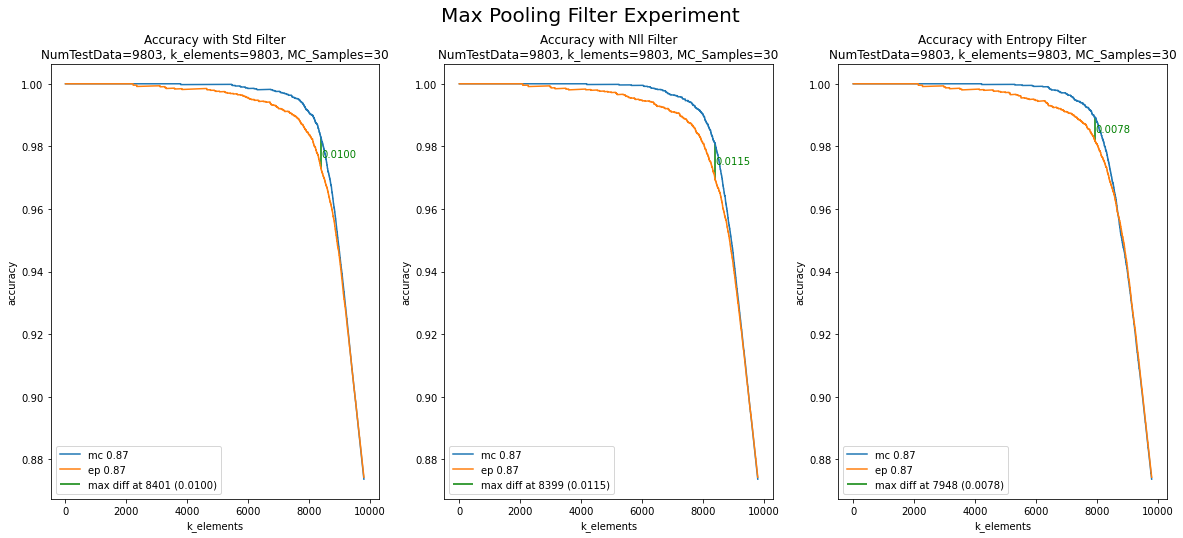

In [21]:
preds_dict = preds_dict_max
k_elements = X_test.shape[0]
plt.figure(figsize=(20,8))

##########################
plt.subplot(1,3,1)
plt.suptitle("Max Pooling Filter Experiment\n",fontsize=20)

mc_results = unc_filtered_acc_loop(preds_dict[0],'std',k_elements)
ep_results = unc_filtered_acc_loop(preds_dict[1],'std',k_elements)

'''Plot the results'''
plt.plot(mc_results,label=f'mc {mc_results[-1]:.2f}')
plt.plot(ep_results,label=f'ep {ep_results[-1]:.2f}')

'''Plot some additional stuff'''
plot_additional_infos(mc_results,ep_results)

plt.title(f'Accuracy with Std Filter\nNumTestData={len(y_test)}, k_elements={k_elements}, MC_Samples={MC_SAMPLES}')
plt.xlabel('k_elements')
plt.ylabel("accuracy")
plt.legend()

##########################
plt.subplot(1,3,2)

mc_results = unc_filtered_acc_loop(preds_dict[0],'nll',k_elements)
ep_results = unc_filtered_acc_loop(preds_dict[1],'nll',k_elements)

'''Plot the results'''
plt.plot(mc_results,label=f'mc {mc_results[-1]:.2f}')
plt.plot(ep_results,label=f'ep {ep_results[-1]:.2f}')
print(mc_results.shape)

'''Plot some additional stuff'''
plot_additional_infos(mc_results,ep_results)

plt.title(f'Accuracy with Nll Filter\nNumTestData={len(y_test)}, k_lements={k_elements}, MC_Samples={MC_SAMPLES}')
plt.xlabel('k_elements')
plt.ylabel("accuracy")
plt.legend()

##########################
plt.subplot(1,3,3)

mc_results = unc_filtered_acc_loop(preds_dict[0],'entropy',k_elements)
ep_results = unc_filtered_acc_loop(preds_dict[1],'entropy',k_elements)

'''Plot the results'''
plt.plot(mc_results,label=f'mc {mc_results[-1]:.2f}')
plt.plot(ep_results,label=f'ep {ep_results[-1]:.2f}')

'''Plot some additional stuff'''
plot_additional_infos(mc_results,ep_results)

plt.title(f'Accuracy with Entropy Filter\nNumTestData={len(y_test)}, k_elements={k_elements}, MC_Samples={MC_SAMPLES}')
plt.xlabel('k_elements')
plt.ylabel("accuracy")
plt.legend()

plt.show()

(9800,)


C:\Users\MJY\Anaconda3\envs\tensorflow2-g2\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
C:\Users\MJY\Anaconda3\envs\tensorflow2-g2\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(9800,)


C:\Users\MJY\Anaconda3\envs\tensorflow2-g2\lib\site-packages\ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


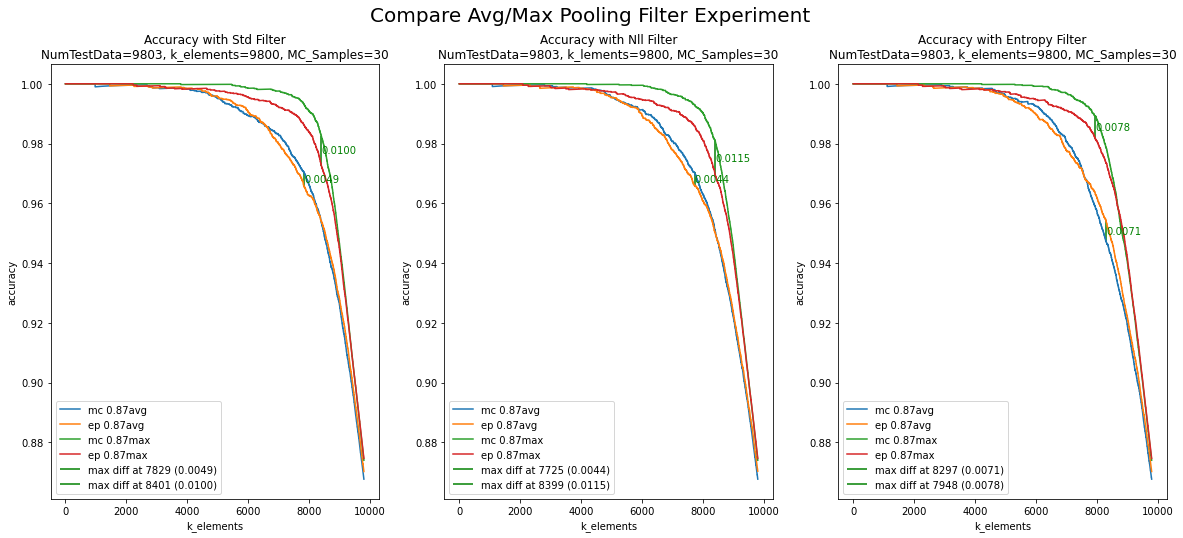

In [22]:
list_avg_max = [preds_dict_avg,preds_dict_max]
plt.figure(figsize=(20,8))
draw_label = ['avg','max']
for i in range(2):
    preds_dict = list_avg_max[i]
    k_elements = 9800

    ##########################
    plt.subplot(1,3,1)
    plt.suptitle("Compare Avg/Max Pooling Filter Experiment\n",fontsize=20)

    mc_results = unc_filtered_acc_loop(preds_dict[0],'std',k_elements)
    ep_results = unc_filtered_acc_loop(preds_dict[1],'std',k_elements)

    '''Plot the results'''
    plt.plot(mc_results,label=f'mc {mc_results[-1]:.2f}'+draw_label[i])
    plt.plot(ep_results,label=f'ep {ep_results[-1]:.2f}'+draw_label[i])

    '''Plot some additional stuff'''
    plot_additional_infos(mc_results,ep_results)

    plt.title(f'Accuracy with Std Filter\nNumTestData={len(y_test)}, k_elements={k_elements}, MC_Samples={MC_SAMPLES}')
    plt.xlabel('k_elements')
    plt.ylabel("accuracy")
    plt.legend()
    
    ##########################
    plt.subplot(1,3,2)

    mc_results = unc_filtered_acc_loop(preds_dict[0],'nll',k_elements)
    ep_results = unc_filtered_acc_loop(preds_dict[1],'nll',k_elements)

    '''Plot the results'''
    plt.plot(mc_results,label=f'mc {mc_results[-1]:.2f}'+draw_label[i])
    plt.plot(ep_results,label=f'ep {ep_results[-1]:.2f}'+draw_label[i])
    print(mc_results.shape)

    '''Plot some additional stuff'''
    plot_additional_infos(mc_results,ep_results)

    plt.title(f'Accuracy with Nll Filter\nNumTestData={len(y_test)}, k_lements={k_elements}, MC_Samples={MC_SAMPLES}')
    plt.xlabel('k_elements')
    plt.ylabel("accuracy")
    plt.legend()
    ##########################
    plt.subplot(1,3,3)

    mc_results = unc_filtered_acc_loop(preds_dict[0],'entropy',k_elements)
    ep_results = unc_filtered_acc_loop(preds_dict[1],'entropy',k_elements)

    '''Plot the results'''
    plt.plot(mc_results,label=f'mc {mc_results[-1]:.2f}'+draw_label[i])
    plt.plot(ep_results,label=f'ep {ep_results[-1]:.2f}'+draw_label[i])

    '''Plot some additional stuff'''
    plot_additional_infos(mc_results,ep_results)

    plt.title(f'Accuracy with Entropy Filter\nNumTestData={len(y_test)}, k_elements={k_elements}, MC_Samples={MC_SAMPLES}')
    plt.xlabel('k_elements')
    plt.ylabel("accuracy")
    plt.legend()

结论：max pooling 明显优于 avg pooling
我觉得原因是max pooling适用于包含较多的无关信息的图片，如背景，但是avg pooling适用于像素特征中的信息都具有一定贡献的时候，如语义分割。
而交通标识数据集分类问题与语义分割不同，提取的特征可能仅仅是中间部分的图案和标识的形状（三角形或是圆形）

此外，为什么会产生初期的迅速下降，可能是因为初期的图片，有些迷惑性过于强，比如像素很不清晰下的马和鹿，这样网络将马认成鹿，不确定性也会很小

### ROC曲线

In [23]:
# 先对std做归一化处理：保证std能被当作阈值0-1
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

In [24]:
def plot_roc(preds_mc_or_ep, measurement):

    tpr = []
    fpr = []
    
    # std归一化
    std_norm = normalization(preds_mc_or_ep[measurement])
    
    area = 0
    
    # 计算roc上的点
    for t in threshold:

        bool_in_set_by_std = std_norm < t  # 小于阈值的我认为都是class1:内样本,否则就是class2:外样本
        bool_in_set_true = np.isin(preds_mc_or_ep["true_label"],[1,11,21,31,41],invert=True)  # 事实上是否为内外样本
         # 真阳性TP：是内样本，并且也被预测为内样本
        TP = np.sum((bool_in_set_by_std == bool_in_set_true)&(bool_in_set_by_std)&(bool_in_set_true))
        # 伪阳性FP：是外样本，但是被预测为内样本
        FP = np.sum((bool_in_set_by_std != bool_in_set_true)&(bool_in_set_by_std==True)&(bool_in_set_true==False))
        # 伪阴性FN：是内样本，但是被预测为外样本
        FN = np.sum((bool_in_set_by_std != bool_in_set_true)&(bool_in_set_by_std==False)&(bool_in_set_true==True))
        # 真阴性TN：是外样本，也被预测为外样本
        TN = np.sum((bool_in_set_by_std == bool_in_set_true)&(bool_in_set_by_std==False)&(bool_in_set_true==False))

        # 接下来算：真正类率TPR， 负正类率FPR   (分别为纵、横坐标)
        TPR=TP/(TP+FN) 
        FPR=FP/(FP+TN) 

        tpr.append(TPR)
        fpr.append(FPR)
    
#     plt.figure(figsize=(5,5))
    plt.plot(fpr,tpr)
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    
    # 计算曲线下面积：
    for i in range(len(tpr)-1):
        area = area + (tpr[i] + tpr[i+1])*(fpr[i+1] - fpr[i])/2   # 梯形方法求AOC面积
    
    Q1 = area/(2-area)
    Q2 = 2*area**2 / (1+area)
    
    bool_in_set_false = np.isin(preds_mc_or_ep["true_label"],[1,11,21,31,41],invert=False)  # 事实上是否为内外样本
    N1 = np.sum(bool_in_set_true)
    N2 = np.sum(bool_in_set_false)
    
    numerator = area*(1-area) + (N1-1)*(Q1-area**2) + (N2-1)*(Q2-area**2)
    denominator = N1*N2
    segma = np.sqrt(numerator/denominator)
    
    return area,segma


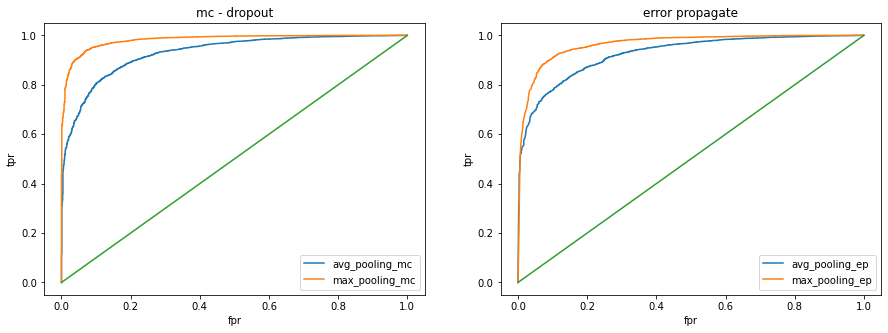

In [25]:
list_avg_max = [preds_dict_avg,preds_dict_max]

threshold = np.arange(0,1.0001,0.0001)

plt.figure(figsize=(15,5))

AUC_SE_mc=[]
AUC_SE_ep=[]

# 放在一起
plt.subplot(121)
for i in range(2):
    AUC_SE_mc.append(plot_roc(list_avg_max[i][0],"std"))
plt.legend(('avg_pooling_mc', 'max_pooling_mc'), loc='lower right')
plt.title("mc - dropout")
plt.plot([0,1],[0,1])

# list_avg_max
plt.subplot(122)
for i in range(2):
    AUC_SE_ep.append(plot_roc(list_avg_max[i][1],"std"))
plt.title("error propagate")
plt.legend(('avg_pooling_ep', 'max_pooling_ep'), loc='lower right')
plt.plot([0,1],[0,1])

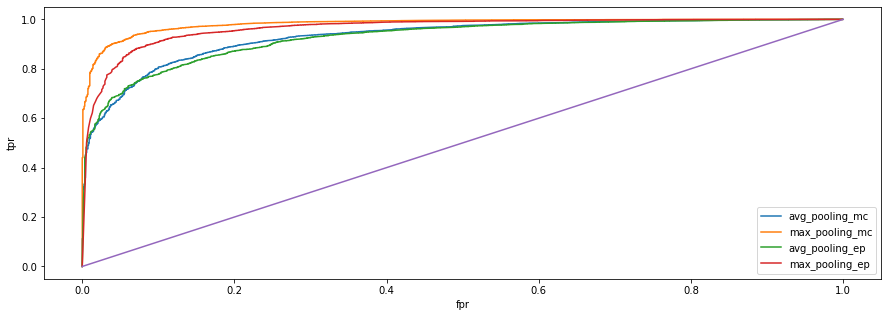

In [29]:
list_avg_max = [preds_dict_avg,preds_dict_max]

threshold = np.arange(0,1.0001,0.0001)

plt.figure(figsize=(15,5))

AUC_SE_mc=[]
AUC_SE_ep=[]

# 放在一起
for i in range(2):
    AUC_SE_mc.append(plot_roc(list_avg_max[i][0],"std"))
# list_avg_max
for i in range(2):
    AUC_SE_ep.append(plot_roc(list_avg_max[i][1],"std"))
plt.legend(('avg_pooling_mc', 'max_pooling_mc','avg_pooling_ep', 'max_pooling_ep'), loc='lower right')
plt.plot([0,1],[0,1])

### 计算置信区间

In [26]:
draw_label = ['avg','max']
AUC_SE_mc,AUC_SE_ep

([(0.9291057965319444, 0.0027025069153414523),
  (0.9811316066248267, 0.0011624702908552928)],
 [(0.9244308835030368, 0.002823197416979216),
  (0.9631769876217914, 0.001751825028404109)])

In [27]:
for i in range(2):
    print("the confidence interval of %s-mc: %.6f ± %.6f" % (draw_label[i],AUC_SE_mc[i][0],2*AUC_SE_mc[i][1]))
for i in range(2):
    print("the confidence interval of %s-ep: %.6f ± %.6f" % (draw_label[i],AUC_SE_ep[i][0],2*AUC_SE_ep[i][1]))

the confidence interval of avg-mc: 0.929106 ± 0.005405
the confidence interval of max-mc: 0.981132 ± 0.002325
the confidence interval of avg-ep: 0.924431 ± 0.005646
the confidence interval of max-ep: 0.963177 ± 0.003504
